# Alex Liddle
## University of Denver

# Chatbot
A chatbot is an intelligent piece of software that is capable of communicating and performing actions similar to a human. The goal of this project is to build a model that predicts answers using predefined patterns and responses. You are provided with a file named intents.json that contains these patterns. Words and classes files are provided as extra help. Feel free to make a more complex bot by extending the intents file. 

#### Possible chat with your bot
<code>
You: Hello, how are you? 
Bot: Hi there, how can I help?
You: what can you do?
Bot: I can guide you through Adverse drug reaction list, Blood pressure tracking, Hospitals and Pharmacies
You: thanks
Bot: My pleasure
You: see ya. got to go!
Bot: See you
</code>

In [153]:
import nltk
import string
import re
import sklearn
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from scipy import stats
#nltk.download('stopwords') #<---uncomment if you haven't downloaded the stopwords library
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
import gensim
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [120]:
# Load pickle files
import urllib.request
import pickle

classes = pickle.load(urllib.request.urlopen("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectPCB/data/classes.pkl"))
words   = pickle.load(urllib.request.urlopen("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectPCB/data/words.pkl"))
words += ['are', 'can', 'do']#how', 'what', 'you', 'do', 'can']

In [121]:
# Load json file with answer patterns
import requests
import json

intents = json.loads(requests.get("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectPCB/data/intents.json").text)
#intents

Process patterns for nlp and clustering

In [122]:
df = pd.DataFrame(intents['intents'])
# explode pattern fields into new rows
df_intents = pd.DataFrame({
              col:np.repeat(df[col].values, df['patterns'].str.len())
              for col in df.columns.difference(['patterns'])
          }).assign(**{'patterns':np.concatenate(df['patterns'].values)})[df.columns.tolist()]
# re-add rows with no pattern
df_intents = df_intents.append(pd.DataFrame([{'context':d['context'], 
                                              'patterns':'', 
                                              'responses':d['responses'], 
                                              'tag':d['tag']} 
                                             for d in intents['intents'] if d['patterns']==[]])).reset_index()

In [208]:
tqdm.pandas()
stop = stopwords.words()

df_intents['patterns_tfidf'] = [[]]*len(df_intents.patterns.values)
df_intents['patterns_word2vec'] = [[]]*len(df_intents.patterns.values)
df_intents['stemmed_pattern'] = ['']*len(df_intents.patterns.values)
corpus = []

for idx, val in df_intents.patterns.items():
    # Normalize words (i.e., convert to same case)
    lowered = val.replace("[^\w\s]", "").lower().split()
    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in lowered]
    # Remove stop words
    stops_removed = [item for item in stripped if (item in words) or (item not in stop)]
    # Stem words
    porter = nltk.PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in stops_removed]
    stemmed = ' '.join([porter.stem(word) for word in lemmatized])
    stemmed_underscore = '_'.join([porter.stem(word) for word in lemmatized])
    # make new column for cleaned text
    df_intents.at[idx, 'patterns_tfidf'] = stemmed
    df_intents.at[idx, 'patterns_word2vec'] = simple_preprocess(stemmed)
    corpus.append(TaggedDocument(simple_preprocess(stemmed), [idx]))#_underscore
    df_intents.at[idx, 'stemmed_pattern'] = ' '.join(simple_preprocess(stemmed))
    
# Vectorize text
tfidf = TfidfVectorizer(
    min_df = 0,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english', 
)

tfidf.fit(df_intents.patterns_tfidf)
patterns_tfidf = tfidf.transform(df_intents.patterns_tfidf)

df_intents.patterns_tfidf = patterns_tfidf

# Build Word2Vec model
#print(corpus)
word2vec_model = gensim.models.doc2vec.Doc2Vec(vector_size=15, min_count=1, epochs=1000)
word2vec_model.build_vocab(corpus)
word2vec_model.train(corpus, total_examples=word2vec_model.corpus_count, epochs=1000)
wordvectors = word2vec_model.wv
df_intents.patterns_word2vec = df_intents.patterns_word2vec.apply(lambda x: word2vec_model.infer_vector(x))

# Bag of Words
# TODO

# remove duplicate patterns
df_intents = df_intents.copy()[:48]
patterns_tfidf = patterns_tfidf.copy()[:48]

df_intents

,index,tag,patterns,responses,context,patterns_tfidf,patterns_word2vec,stemmed_pattern,patterns_cluster
0,0,greeting,Hi there,"[Hello, thanks for asking, Good to see you aga...",[],"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...","[-1.5752022, -1.1429696, 0.09607094, -0.780605...",hi there,13
1,1,greeting,How are you,"[Hello, thanks for asking, Good to see you aga...",[],"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...","[0.12385665, -1.1956689, 0.9695102, 0.66695577...",how are you,0
2,2,greeting,Is anyone there?,"[Hello, thanks for asking, Good to see you aga...",[],"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...","[-1.9066889, -0.8504994, 0.7736463, 0.29936975...",is anyon there,23
3,3,greeting,Hey,"[Hello, thanks for asking, Good to see you aga...",[],"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...","[-1.5030901, -1.1714087, 1.2648414, -0.7709167...",hey,27
4,4,greeting,Hola,"[Hello, thanks for asking, Good to see you aga...",[],"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...","[-1.2812002, -0.4431773, 0.4033981, -0.0193813...",hola,18
5,5,greeting,Hello,"[Hello, thanks for asking, Good to see you aga...",[],"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...","[-0.08619033, -0.5437457, 0.039118614, -0.7800...",hello,19
6,6,greeting,Good day,"[Hello, thanks for asking, Good to see you aga...",[],"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...","[-2.6857975, -1.1254673, -0.9044623, -0.757865...",good day,26
7,7,goodbye,Bye,"[See you!, Have a nice day, Bye! Come back aga...",[],"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...","[0.32452783, -1.9428594, 0.38618883, 0.0398261...",bye,31
8,8,goodbye,See you later,"[See you!, Have a nice day, Bye! Come back aga...",[],"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...","[1.7465516, -1.1134744, -0.6129173, -2.750584,...",see you later,15
9,9,goodbye,Goodbye,"[See you!, Have a nice day, Bye! Come back aga...",[],"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...","[0.7340739, 0.7224577, 0.04038231, -1.1837283,...",goodby,17


In [198]:
def find_optimal_clusters(data, max_k):    
    k_list = range(2, max_k+1)
    
    sse = []
    for k in k_list:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            #sse.append(KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(data).inertia_)
            sse.append(MiniBatchKMeans(n_clusters=k, random_state=42).fit(data).inertia_)

    plt.style.use("dark_background")
    f, ax = plt.subplots(1, 1, figsize=(15,15))
    ax.plot(k_list, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(k_list)
    ax.set_xticklabels(k_list)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

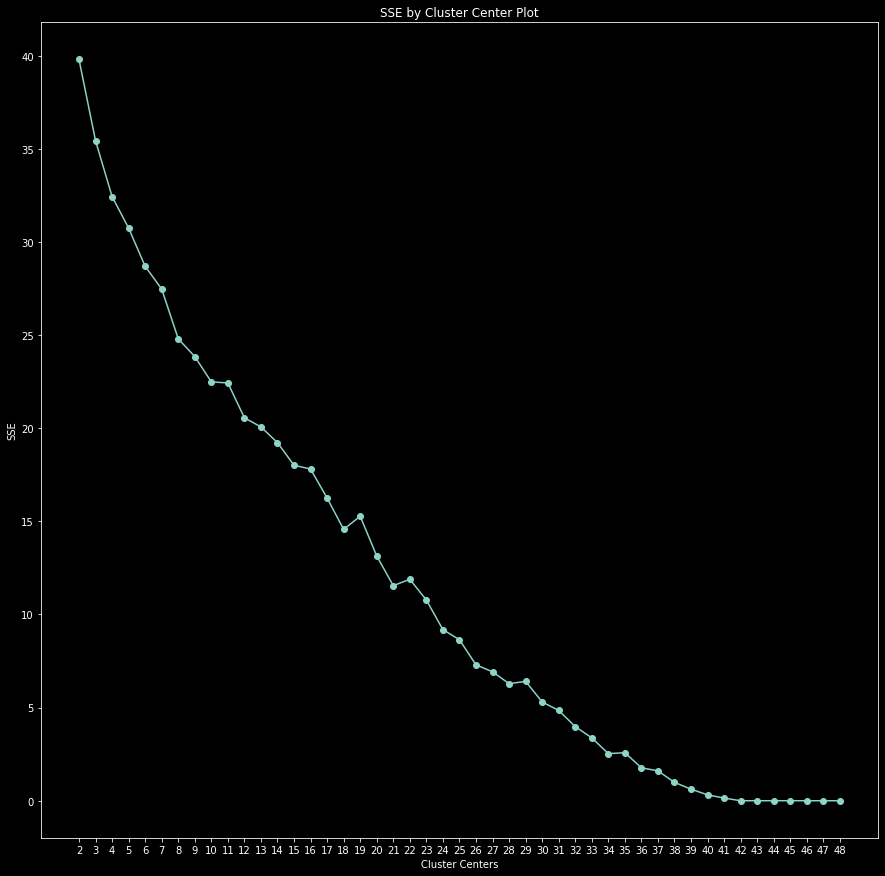

In [199]:
find_optimal_clusters(patterns_tfidf, patterns_tfidf.shape[0])

In [200]:
n_clusters = 42

#model = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1).fit(patterns_tfidf)

model = MiniBatchKMeans(n_clusters=n_clusters, random_state=42).fit(patterns_tfidf)

df_intents['patterns_cluster'] = model.predict(patterns_tfidf)
df_intents

,index,tag,patterns,responses,context,patterns_tfidf,patterns_word2vec,stemmed_pattern,patterns_cluster
0,0,greeting,Hi there,"[Hello, thanks for asking, Good to see you aga...",[],"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...","[0.0051456536, -0.00444179, -0.006222257, -0.0...",hi there,13
1,1,greeting,How are you,"[Hello, thanks for asking, Good to see you aga...",[],"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...","[0.0039934707, -0.00226934, -0.0055430513, 0.0...",how are you,0
2,2,greeting,Is anyone there?,"[Hello, thanks for asking, Good to see you aga...",[],"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...","[0.005122468, -0.007976083, -0.009413301, -0.0...",is anyon there,23
3,3,greeting,Hey,"[Hello, thanks for asking, Good to see you aga...",[],"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...","[-0.0073695127, 0.0076882043, -0.009868565, 0....",hey,27
4,4,greeting,Hola,"[Hello, thanks for asking, Good to see you aga...",[],"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...","[-0.0036944107, -0.005942804, 0.005642811, -0....",hola,18
5,5,greeting,Hello,"[Hello, thanks for asking, Good to see you aga...",[],"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...","[0.0060961903, 0.008054482, -0.005741853, 0.00...",hello,19
6,6,greeting,Good day,"[Hello, thanks for asking, Good to see you aga...",[],"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...","[-0.008781895, 0.0048117065, -0.004381481, 0.0...",good day,26
7,7,goodbye,Bye,"[See you!, Have a nice day, Bye! Come back aga...",[],"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...","[0.0031451487, -0.0039353077, -0.0050526173, -...",bye,31
8,8,goodbye,See you later,"[See you!, Have a nice day, Bye! Come back aga...",[],"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...","[-0.007857265, 0.0021515794, -0.006970268, -0....",see you later,15
9,9,goodbye,Goodbye,"[See you!, Have a nice day, Bye! Come back aga...",[],"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...","[0.00026096398, 0.0026037868, 0.007209139, -0....",goodby,17


TfidfVector

In [201]:
user_prompt = ''

prompts = df_intents.patterns.values
responses = df_intents.responses.values

i = 0

missed = 0

print('Testing Chatbot')
print('-----------------------')

while True:
    user_prompt = prompts[i] #input("User: ")
    if user_prompt.lower()=='q':
        break
    lowered = user_prompt.replace("[^\w\s]", "").lower().split()
    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in lowered]
    # Remove stop words
    stops_removed = [item for item in stripped if (item in words) or (item not in stop)]
    # Stem and lemmatize words
    porter = nltk.PorterStemmer()
    lemmatized = [lemmatizer.lemmatize(word) for word in stops_removed]
    stemmed = ' '.join([porter.stem(word) for word in lemmatized])
    
    # vectorize
    test_vector = tfidf.transform([stemmed])

    predicted_cluster = model.predict(test_vector)[0]

    response = np.random.choice(list(df_intents[df_intents.patterns_cluster==predicted_cluster].responses)[0])

    r = responses[i]
    if response not in r:
        r = r[0]
        missed +=1
    else:
        r = response
    
    print('\nprompt:', user_prompt)
    print('predicted:', response)
    print('true:', r)
        
    i += 1
    if i==len(prompts):
        break

print('-----------------------')
print('\n\nModel Accuracy:',(len(prompts)-missed)/len(prompts))

Testing Chatbot
-----------------------

prompt: Hi there
predicted: Good to see you again
true: Good to see you again

prompt: How are you
predicted: Hello, thanks for asking
true: Hello, thanks for asking

prompt: Is anyone there?
predicted: Hi there, how can I help?
true: Hi there, how can I help?

prompt: Hey
predicted: Hi there, how can I help?
true: Hi there, how can I help?

prompt: Hola
predicted: Hi there, how can I help?
true: Hi there, how can I help?

prompt: Hello
predicted: Hi there, how can I help?
true: Hi there, how can I help?

prompt: Good day
predicted: Good to see you again
true: Good to see you again

prompt: Bye
predicted: Bye! Come back again soon.
true: Bye! Come back again soon.

prompt: See you later
predicted: See you!
true: See you!

prompt: Goodbye
predicted: Bye! Come back again soon.
true: Bye! Come back again soon.

prompt: Nice chatting to you, bye
predicted: Bye! Come back again soon.
true: Bye! Come back again soon.

prompt: Till next time
predicted:

Word2Vec

In [210]:
user_prompt = ''

prompts = df_intents.patterns.values
responses = df_intents.responses.values

i = 0

missed = 0

print('Testing Chatbot')
print('-----------------------')

while True:
    user_prompt = prompts[i] #input("User: ")
    if user_prompt.lower()=='q':
        break
    lowered = user_prompt.replace("[^\w\s]", "").lower().split()
    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in lowered]
    # Remove stop words
    stops_removed = [item for item in stripped if (item in words) or (item not in stop)]
    # Stem and lemmatize words
    porter = nltk.PorterStemmer()
    lemmatized = [lemmatizer.lemmatize(word) for word in stops_removed]
    stemmed = ' '.join([porter.stem(word) for word in lemmatized])
    
    # vectorize
    inferred_vector = word2vec_model.infer_vector(simple_preprocess(stemmed))
    #print(help(word2vec_model))
    # find similar phrases
    similar = word2vec_model.docvecs.most_similar([inferred_vector])
    similar = ' '.join(corpus[similar[0][0]].words)
    response = np.random.choice(list(df_intents.loc[df_intents.stemmed_pattern==similar]['responses'])[0])
        
    if user_prompt == "":
        response = "Sorry, can't understand you"
    r = responses[i]
    if response not in r:
        r = r[0]
        missed +=1
    else:
        r = response
    
    print('\nprompt:', user_prompt)
    print('predicted:', response)
    print('true:', r)
        
    i += 1
    if i==len(prompts):
        break

print('-----------------------')
print('\n\nModel Accuracy:',(len(prompts)-missed)/len(prompts))

Testing Chatbot
-----------------------

prompt: Hi there
predicted: Good to see you again
true: Good to see you again

prompt: How are you
predicted: Good to see you again
true: Good to see you again

prompt: Is anyone there?
predicted: Good to see you again
true: Good to see you again

prompt: Hey
predicted: Hello, thanks for asking
true: Hello, thanks for asking

prompt: Hola
predicted: Hi there, how can I help?
true: Hi there, how can I help?

prompt: Hello
predicted: Good to see you again
true: Good to see you again

prompt: Good day
predicted: Hello, thanks for asking
true: Hello, thanks for asking

prompt: Bye
predicted: Bye! Come back again soon.
true: Bye! Come back again soon.

prompt: See you later
predicted: Bye! Come back again soon.
true: Bye! Come back again soon.

prompt: Goodbye
predicted: Bye! Come back again soon.
true: Bye! Come back again soon.

prompt: Nice chatting to you, bye
predicted: Bye! Come back again soon.
true: Bye! Come back again soon.

prompt: Till ne

Bag of Words